In [1]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
from Unet import UNet

In [2]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [3]:
import os
import glob
import cv2
import sys
from tqdm import tqdm
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset

import albumentations as A
import torchvision.transforms as transforms


class DirDataset(Dataset):
    def __init__(self, img_dir, mask_dir, scale=1, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        #print(img_dir)
        print(mask_dir)
        self.scale = scale
        try:
            self.ids = [s.split('.')[0] for s in os.listdir(self.img_dir)]
        except FileNotFoundError:
            self.ids = []

    def __len__(self):
        return len(self.ids)

    def preprocess(self, img, is_mask=False):
        w, h = img.size
        _h = 800
        _w = 800
        assert _w > 0
        assert _h > 0

        if not is_mask:
            _img = img.resize((_w, _h))
            _img = np.array(_img)
            if len(_img.shape) == 2:  # Gray/mask images
                _img = np.expand_dims(_img, axis=-1)

            # HWC to CHW
            _img = _img.transpose((2, 0, 1))
            if _img.max() > 1:
                _img = _img / 255.
        else:
            _img = img.resize((_w, _h), Image.NEAREST)

        return _img
    def __getitem__(self, i):
        print("here-----------")
        idx = self.ids[i]
        mask_idx = idx.split("_aug")[0] if len(idx.split("_aug")) > 1 else idx
        img_files = glob.glob(os.path.join(self.img_dir, idx + '.*'))
        mask_files = glob.glob(os.path.join(self.mask_dir, mask_idx + '.*'))

        assert len(img_files) == 1, f'{idx}: {img_files}'
        assert len(mask_files) == 1, f'{idx}: {mask_files}'

        img = Image.open(img_files[0]).convert("RGB")
        mask = Image.open(mask_files[0]).convert("RGB")  # Ensure it's grayscale
        transform = transforms.Compose([
            transforms.PILToTensor()
        ])
        #print("============")
        #print(type(img), type(mask))
        #print(img.size)
        #print(mask.size)
        img_tensor = transform(img)
        mask_tensor = transform(mask)

        print("============")
        print(type(img_tensor), type(mask_tensor))
        print(img_tensor.shape)
        print(mask_tensor.shape)

        # assert img.size == mask.size, f'{img.shape} # {mask.shape}'

        print(mask_tensor.shape)
        # sys.exit()
        print(type(img))
        print(type(mask))
        img = self.preprocess(img)
        mask = self.preprocess(mask)
        print("============")
        print(type(img_tensor), type(mask_tensor))
        print(img.shape)
        print(mask.shape)

        print("91============")
        # augment images
        if self.transform!=None:
            aug = self.transform(image=img, mask=mask)
            image = aug['image']
            mask = aug['mask']
        print("98============")

        return torch.from_numpy(img).float(), \
            torch.from_numpy(mask).float()

In [4]:

from torch.utils.data import DataLoader, random_split
dataset = 'IAM'
DirDataset.LOAD_TRUNCATED_IMAGES = True
dataset = DirDataset(f'./dataset/{dataset}/input', f'./dataset/{dataset}/cropped_out')
n_val = int(len(dataset) * 0.8)
n_train = len(dataset) - n_val
train_ds, val_ds = random_split(dataset, [n_train, n_val])
# print("train fun==========")#
train_batch = DataLoader(train_ds, batch_size=1, pin_memory=True, shuffle=True)

# print("val fun==========")
test_batch = DataLoader(val_ds, batch_size=1, pin_memory=True, shuffle=False)


./dataset/IAM/cropped_out


here-----------
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 800, 1120])
torch.Size([3, 1770, 2479])
torch.Size([3, 1770, 2479])
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
(3, 800, 800)
(3, 800, 800)
91============
98============
(tensor([[[0.5412, 0.6549, 0.8510,  ..., 0.9333, 0.9255, 0.9608],
         [0.5529, 0.6863, 0.8549,  ..., 0.9451, 0.9255, 0.8980],
         [0.5804, 0.6667, 0.8745,  ..., 0.9569, 0.9176, 0.9176],
         ...,
         [0.5529, 0.5686, 0.6510,  ..., 0.9725, 0.9725, 0.9725],
         [0.5922, 0.6235, 0.6549,  ..., 0.9725, 0.9725, 0.9725],
         [0.5333, 0.6353, 0.6314,  ..., 0.9686, 0.9647, 0.9686]],

        [[0.5412, 0.6549, 0.8510,  ..., 0.9333, 0.9255, 0.9608],
         [0.5529, 0.6863, 0.8549,  ..., 0.9451, 0.9255, 0.8980],
         [0.5804, 0.6667, 0.8745,  ..., 0.9569, 0.9176, 0.9176],
         ...,
         [0.5529, 0.5686, 0.6510,  ..., 0.9725, 0.9725, 0.9725],
         [0.5922, 

TypeError: Invalid shape (3, 800, 800) for image data

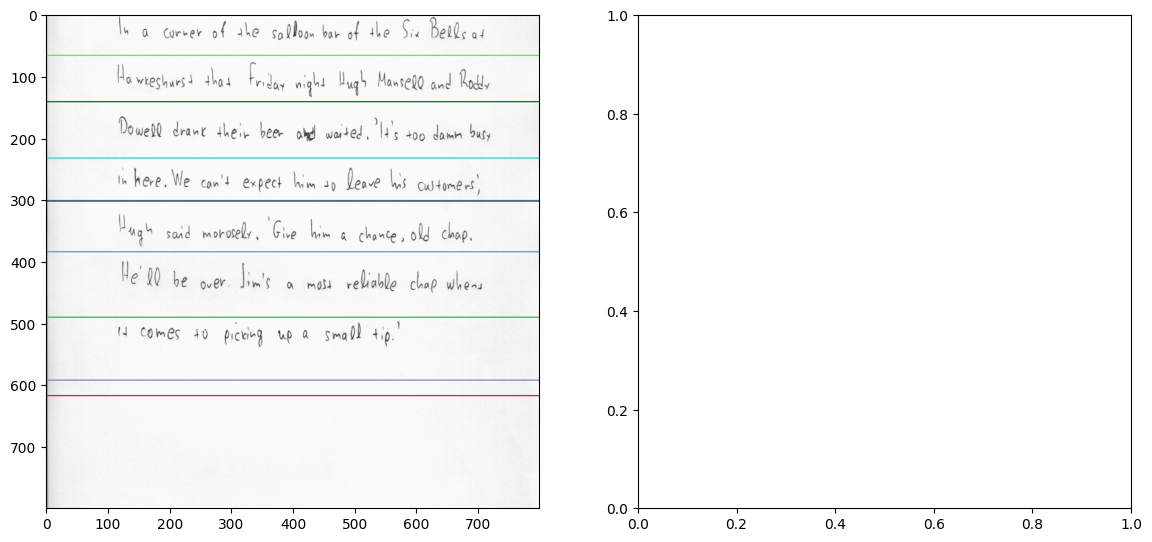

In [5]:
# lets look at some samples
print(train_ds[0])
image, mask = train_ds[0]

plt.figure(figsize = (14, 10))
plt.subplot(1,2,1)
plt.imshow(np.array(image).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(mask).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()


In [7]:
model = UnetFracture()
model.initialize()

In [8]:

image, mask = train_ds[0]
mask_prob = model.predict_proba(image)

here-----------
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 800, 1120])
torch.Size([3, 1770, 2479])
torch.Size([3, 1770, 2479])
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
(3, 800, 800)
(3, 800, 800)
91============
98============


AttributeError: 'torch.dtype' object has no attribute 'type'

In [ ]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.double)
        # forward
        #with torch.cuda.amp.autocast():
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        loss.backward()
	    # Update Optimizer
        optimizer.step()


        # update tqdm loop
        loop.set_postfix(loss=loss.item())
